# ⚖️ Capítulo 7 – Detección de Anomalías con One-Class SVM

En este capítulo se presenta el algoritmo **One-Class Support Vector Machine (One-Class SVM)**, una técnica no supervisada para la detección de anomalías basada en el marco de las máquinas de vectores de soporte.  

Su fortaleza principal reside en que **aprende una frontera en el espacio de características que encierra la mayor parte de los datos considerados normales**, de modo que todo lo que quede fuera se interpreta como una anomalía.  

---

## 🎯 ¿Por qué One-Class SVM?

La elección de One-Class SVM responde a varios motivos:

- Es un modelo **matemáticamente sólido**, derivado de las Máquinas de Vectores de Soporte.  
- Puede modelar **fronteras no lineales complejas** mediante kernels como el RBF.  
- Funciona sin necesidad de etiquetas, lo que lo hace adecuado en contextos industriales donde no se dispone de clasificaciones fiables.  
- Permite un control explícito sobre el **porcentaje esperado de anomalías** mediante el hiperparámetro $ \nu $.  

---

## 🧭 Objetivo de este capítulo

A lo largo del capítulo se presentarán:

- Los fundamentos teóricos del One-Class SVM.  
- Su aplicación sobre datos reales extraídos de archivos MDF.  
- El impacto de distintos kernels y parámetros en la detección.  
- Una comparación cualitativa de sus resultados con los obtenidos por Isolation Forest.  

Además, se discutirán las limitaciones prácticas del modelo, en particular su **sensibilidad a la escala de los datos y al ajuste de hiperparámetros**.  

El capítulo concluirá con la transición hacia modelos de **Deep Learning (Autoencoders)**, que ofrecen mayor capacidad de representación.  

---

## 🔍 Intuición

El One-Class SVM busca encontrar un **hiperplano en el espacio de características** que maximice la separación entre los datos normales y el origen.  

De forma intuitiva:  

> "One-Class SVM encierra la nube de puntos normales dentro de una frontera flexible. Todo lo que se salga de esa frontera se considera anómalo."

---

## 🧠 Fundamento Teórico

El One-Class SVM se formula como un problema de optimización:  

Minimizar:  

$$
\frac{1}{2} \|w\|^2 + \frac{1}{\nu n}\sum_{i=1}^n \xi_i - \rho
$$  

Sujeto a:  

$$
(w \cdot \phi(x_i)) \geq \rho - \xi_i, \quad \xi_i \geq 0
$$  

Donde:

- $ \phi(x) $: transformación del espacio de características mediante el kernel.  
- $ w $: vector de pesos.  
- $ \rho $: umbral que define la frontera.  
- $ \nu \in (0,1] $: parámetro que controla la fracción de outliers y el número de vectores de soporte.  

La función de decisión resultante es:  

$$
f(x) = \text{sign}((w \cdot \phi(x)) - \rho)
$$  

---

## 📐 Función de Decisión y Scores

- **Salida de predicción**: $ f(x) \in \{+1, -1\} $  
  - +1 → Punto normal  
  - -1 → Anómalo  

- **Score de decisión**:  
  Valores continuos que indican qué tan lejos está el punto de la frontera.  
  - Valores grandes y positivos → normales con alta confianza.  
  - Valores cercanos a 0 → puntos ambiguos.  
  - Valores negativos → anomalías.  

---

## ⚙️ Parámetros Clave

- **ν (nu)**: fracción máxima de anomalías esperadas (típicamente entre 0.01 y 0.1).  
- **kernel**: define la forma de la frontera (más usado: RBF).  
- **γ (gamma)**: controla la influencia de cada punto en el kernel RBF.  
- **coef0**: relevante en kernels polinomiales o sigmoides.  

---

## ✅ Ventajas

- Basado en una teoría matemática robusta.  
- Flexible gracias al uso de kernels.  
- Permite ajustar explícitamente el porcentaje esperado de anomalías.  

---

## 🚫 Limitaciones

- **Sensibilidad a la escala de los datos** → requiere normalización/estandarización previa.  
- El rendimiento depende mucho de la elección de **ν** y **γ**.  
- Computacionalmente más costoso que Isolation Forest en datasets grandes.  
- Puede sufrir de **overfitting** si se ajustan mal los parámetros del kernel.  

---

### 🔧 Ejemplo concreto

Supongamos que se analiza el **consumo eléctrico de un vehículo híbrido** en función de dos variables:

- **Nivel de carga de la batería (%)**  
- **Velocidad del vehículo (km/h)**  

En condiciones normales, el sistema de gestión de energía mantiene una relación **no lineal**:  
- A velocidades bajas (20–50 km/h) el coche utiliza más batería.  
- A velocidades medias (80–120 km/h) predomina el motor de combustión y el consumo eléctrico desciende.  
- En frenadas o descensos, incluso puede observarse **recuperación de energía** (consumo negativo).

El One-Class SVM entrenado sobre datos de conducción normal aprenderá una **frontera curva y cerrada** que encierra esta nube de puntos con forma característica.  

Ahora, imaginemos que aparece un punto con:  

- Velocidad = 100 km/h  
- Nivel de batería cayendo bruscamente (como si se descargara a alta potencia)  

Esta situación es **inconsistente con el patrón aprendido**: a esa velocidad, la batería debería estar estable o descargarse muy lentamente.  

➡️ El modelo lo marcará como **anómalo**, ya que cae fuera de la región habitual, revelando un posible fallo en el sistema de gestión energética o en la batería.

---

## 🔗 Referencias

Schölkopf, Bernhard, et al.  
**"Estimating the support of a high-dimensional distribution."** Neural computation 13.7 (2001): 1443-1471.  

Tax, David MJ, and Robert PW Duin.  
**"Support vector data description."** Machine learning 54 (2004): 45-66.  


## 🧪 Validación experimental de One-Class SVM

Para evaluar el rendimiento de nuestro **One-Class SVM**, seguimos el mismo protocolo definido en el resto de modelos:

1. **Partición temporal**: generamos una serie sintética con anomalías inyectadas y dividimos en *train*, *val* y *test*. Unimos **train+val** para la búsqueda de hiperparámetros y reservamos **test** para la evaluación final.
2. **Validación con TSCV**: utilizamos un **Time Series Cross-Validation** con ventanas deslizantes (parámetros `P_train`, `num_windows`, etc.) para respetar la causalidad temporal y evitar *look-ahead*.
3. **Preprocesado consistente**: aplicamos el mismo pipeline de preprocesado (detección/mitigación de outliers con filtro de Hampel, tratamiento estacional si procede y normalización). Este paso es especialmente crítico en SVM, ya que el algoritmo es muy sensible a la escala de las variables.
4. **Búsqueda de hiperparámetros**: realizamos un *grid search* sobre:
   - `ν` (*nu*): fracción máxima de anomalías esperadas (controla el margen de decisión).
   - `kernel`: tipo de kernel (RBF, lineal, polinómico).
   - `γ` (*gamma*): parámetro del kernel RBF que define la influencia local de cada punto.
5. **Métricas**: calculamos **precision**, **recall**, **F1**, **ROC-AUC**, **NAB** y **window coverage**. Seleccionamos las 5 mejores configuraciones de validación según **NAB**.
6. **Evaluación final**: reentrenamos las configuraciones *top-5* en **train+val** y medimos en **test**. Para cada configuración mostramos la curva ROC y la visualización de anomalías detectadas frente a anomalías reales en las señales.

> Nota: en esta implementación, los parámetros `ν` y `γ` juegan un papel análogo al `contamination` en Isolation Forest:  
> - **ν alto** → el modelo considera más puntos como anómalos (mayor *recall*, menor *precision*).  
> - **ν bajo** → el modelo es más estricto, detecta menos anomalías pero con mayor confianza.  
> El *grid search* permite equilibrar esta sensibilidad de acuerdo con las métricas objetivo.


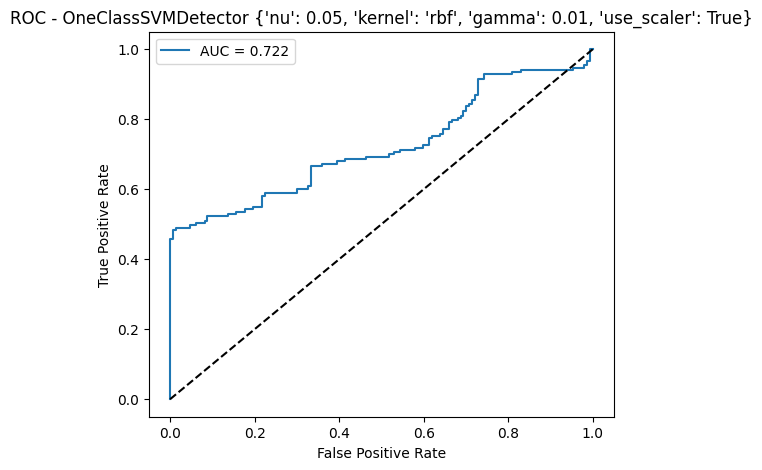

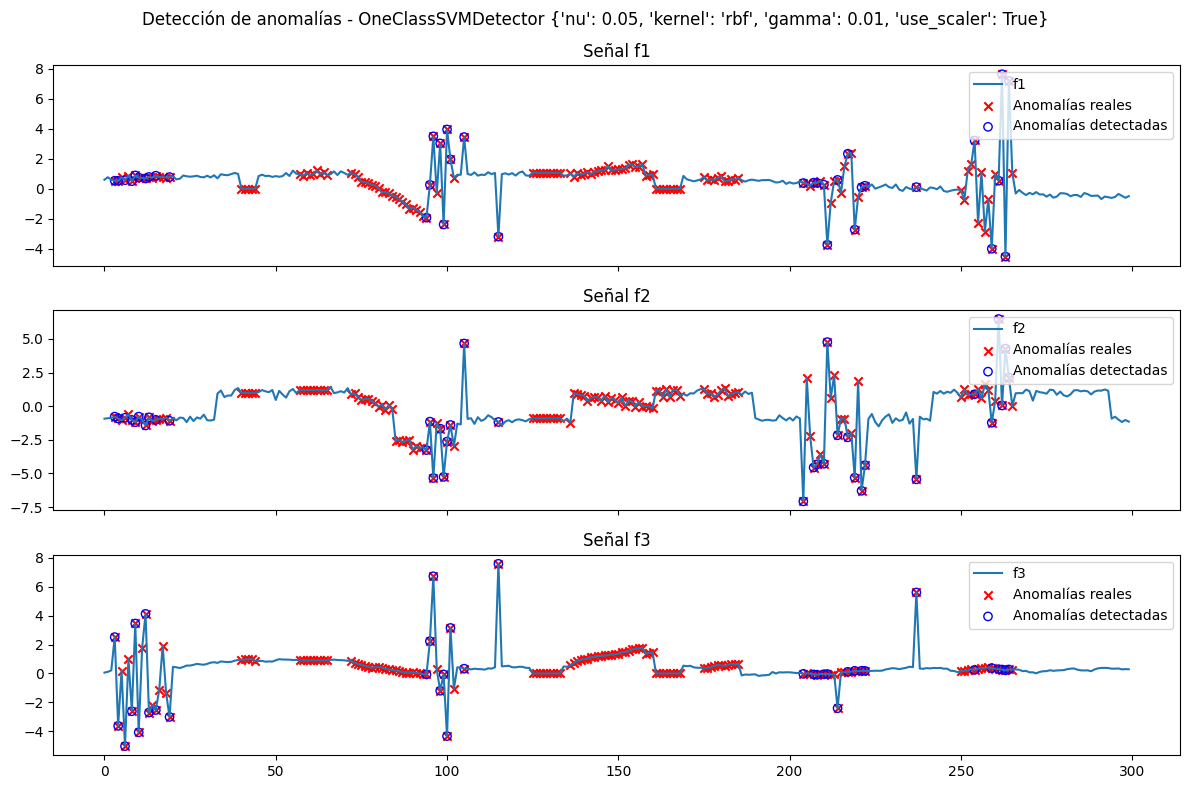

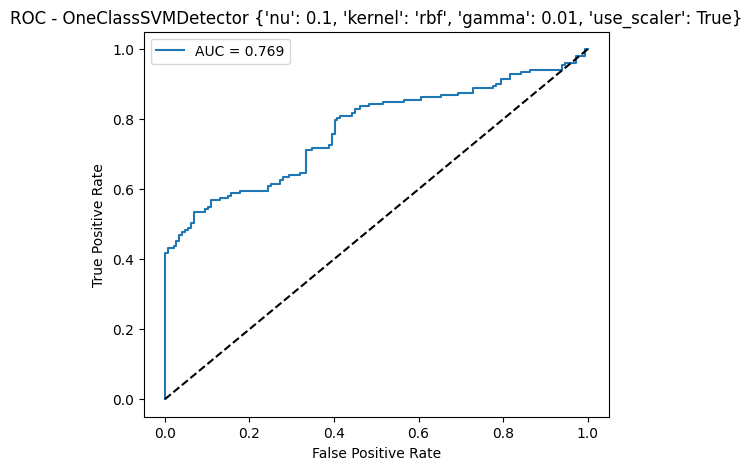

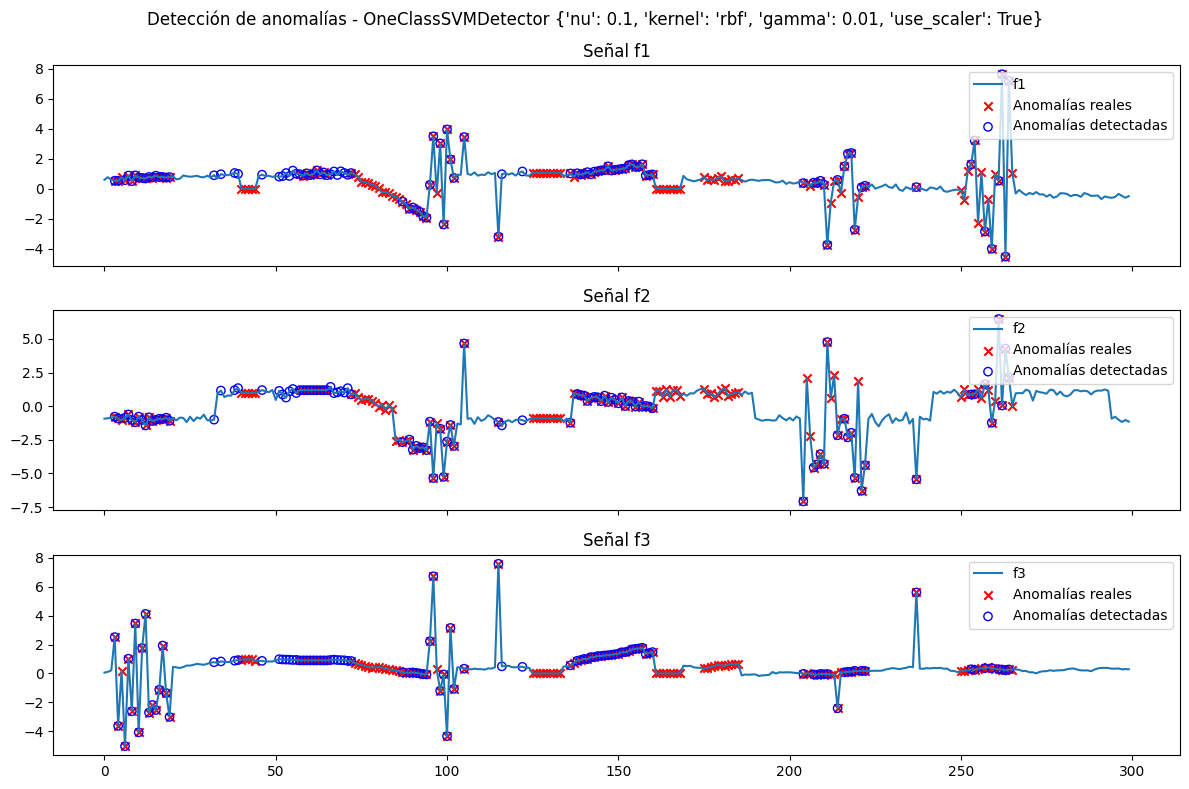

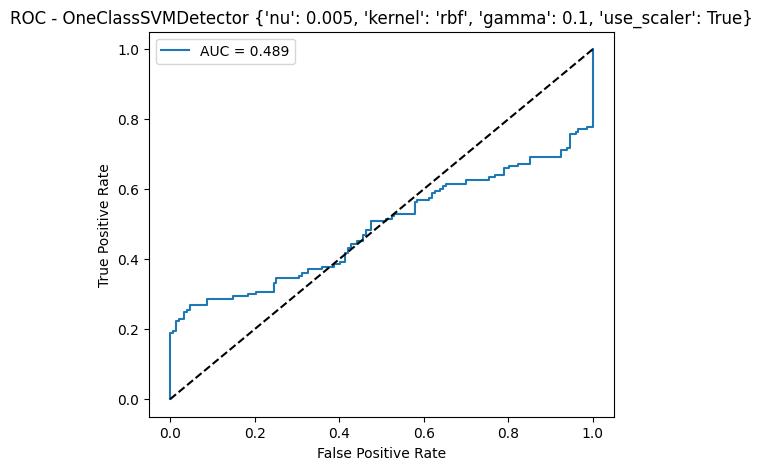

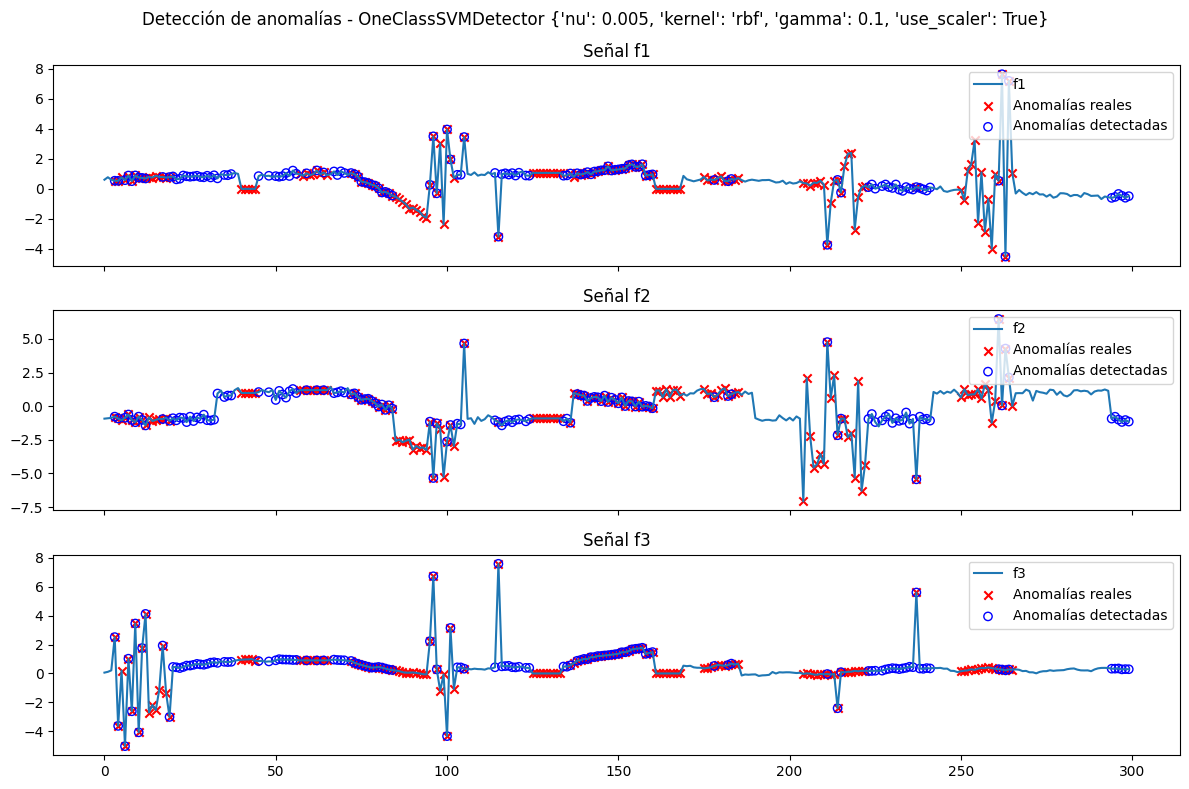

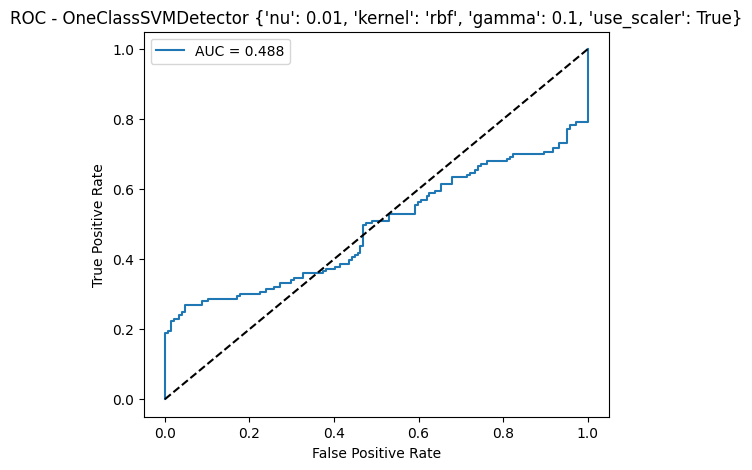

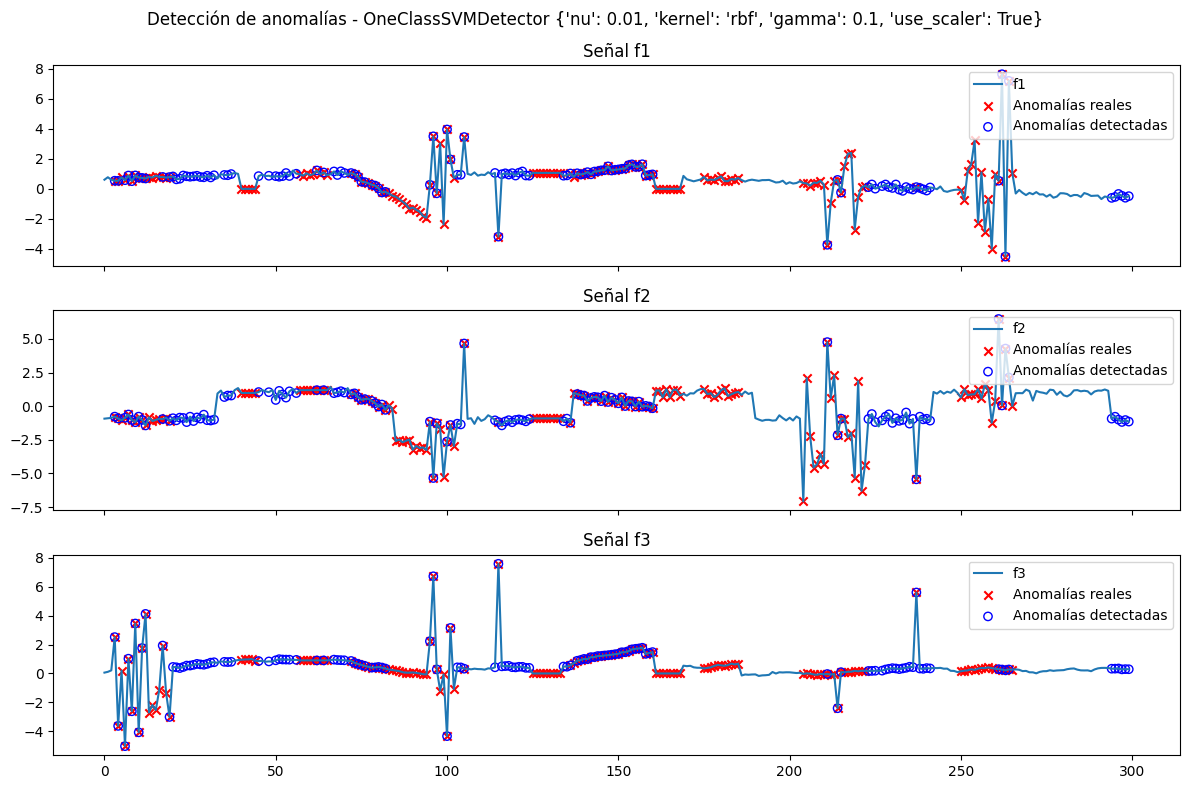

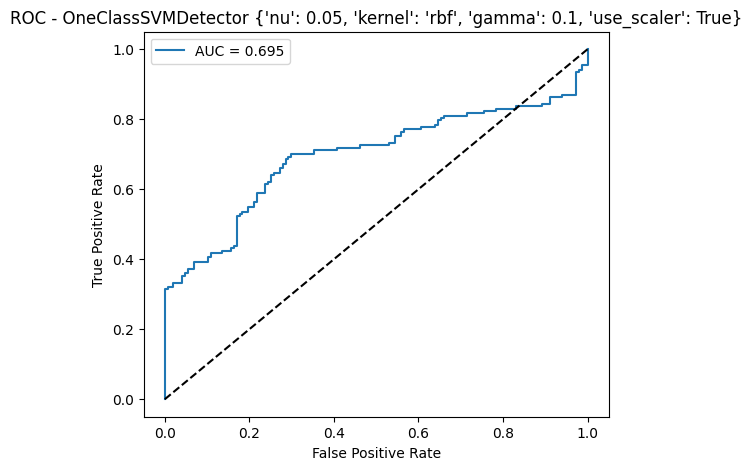

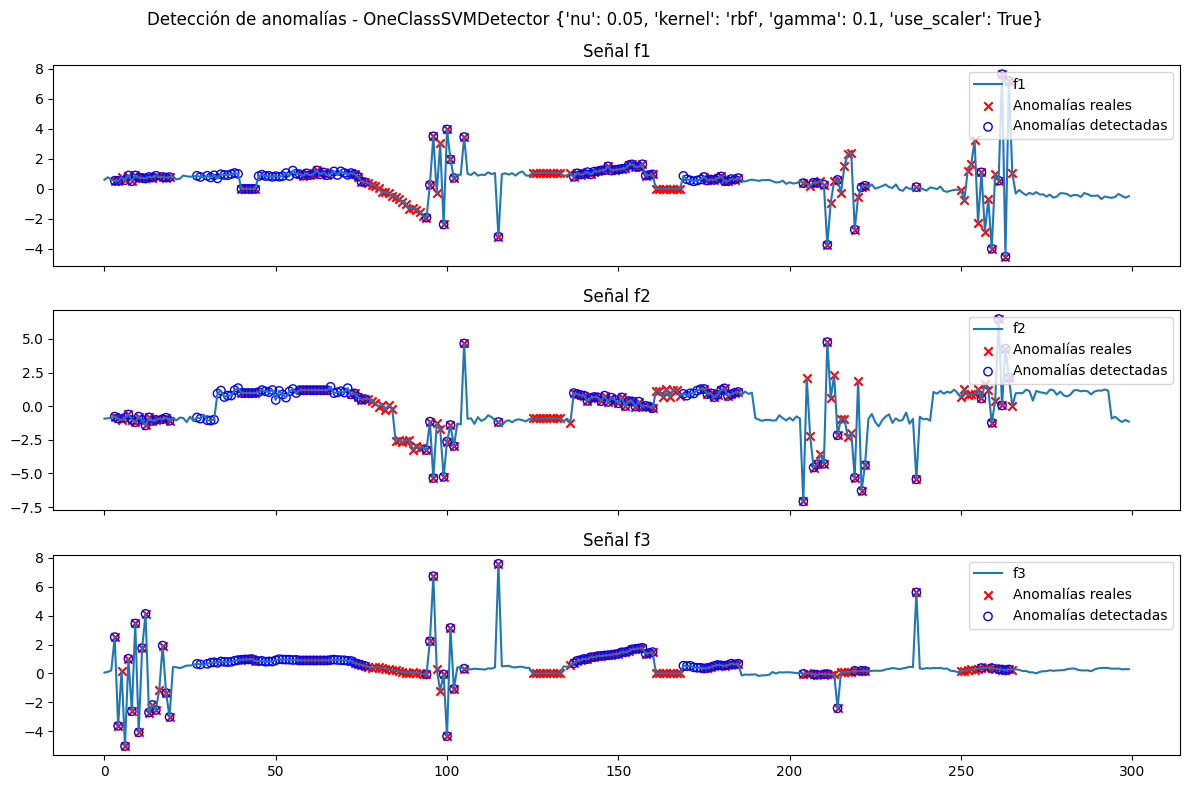

Resultados de validación (grid search en train+val):


,precision,recall,f1,roc_auc,nab,window_cov,nu,kernel,gamma,use_scaler
0,0.539,0.495,0.446,0.774,0.706,0.508,0.005,rbf,scale,True
1,0.534,0.488,0.440,0.776,0.698,0.502,0.005,rbf,auto,True
2,0.437,0.127,0.165,0.879,0.573,0.135,0.005,rbf,0.01,True
3,0.634,0.326,0.372,0.772,0.770,0.352,0.005,rbf,0.1,True
4,0.513,0.585,0.498,0.892,0.635,0.581,0.005,rbf,1.0,True
5,0.576,0.283,0.331,0.647,0.667,0.306,0.005,linear,scale,True
6,0.576,0.283,0.331,0.647,0.667,0.306,0.005,linear,auto,True
7,0.576,0.283,0.331,0.647,0.667,0.306,0.005,linear,0.01,True
8,0.576,0.283,0.331,0.647,0.667,0.306,0.005,linear,0.1,True
9,0.576,0.283,0.331,0.647,0.667,0.306,0.005,linear,1.0,True


Top 5 configuraciones (ordenadas por nab en validación):


,precision,recall,f1,roc_auc,nab,window_cov,nu,kernel,gamma,use_scaler
32,0.624848,0.397103,0.445747,0.873982,0.806352,0.417610,0.050,rbf,0.01,True
42,0.619936,0.486627,0.516298,0.865780,0.778618,0.505130,0.100,rbf,0.01,True
3,0.634461,0.325921,0.371552,0.771690,0.769768,0.352249,0.005,rbf,0.1,True
13,0.635942,0.328150,0.372927,0.773564,0.769768,0.352128,0.010,rbf,0.1,True
33,0.621824,0.427659,0.469639,0.879915,0.768882,0.449105,0.050,rbf,0.1,True


Resultados finales en TEST (top-5 configs):


,nu,kernel,gamma,use_scaler,precision,recall,f1,roc_auc,nab,window_cov
0,0.050,rbf,0.01,True,1.000,0.235,0.381,0.722,0.555,0.393
1,0.100,rbf,0.01,True,0.822,0.575,0.677,0.769,0.883,0.611
2,0.005,rbf,0.10,True,0.511,0.451,0.479,0.489,0.877,0.497
3,0.010,rbf,0.10,True,0.488,0.405,0.443,0.488,0.802,0.457
4,0.050,rbf,0.10,True,0.723,0.614,0.664,0.695,0.907,0.737


Resultados de validación (grid search en train+val):


,precision,recall,f1,roc_auc,nab,window_cov,nu,kernel,gamma,use_scaler
0,0.539,0.495,0.446,0.774,0.706,0.508,0.005,rbf,scale,True
1,0.534,0.488,0.440,0.776,0.698,0.502,0.005,rbf,auto,True
2,0.437,0.127,0.165,0.879,0.573,0.135,0.005,rbf,0.01,True
3,0.634,0.326,0.372,0.772,0.770,0.352,0.005,rbf,0.1,True
4,0.513,0.585,0.498,0.892,0.635,0.581,0.005,rbf,1.0,True
5,0.576,0.283,0.331,0.647,0.667,0.306,0.005,linear,scale,True
6,0.576,0.283,0.331,0.647,0.667,0.306,0.005,linear,auto,True
7,0.576,0.283,0.331,0.647,0.667,0.306,0.005,linear,0.01,True
8,0.576,0.283,0.331,0.647,0.667,0.306,0.005,linear,0.1,True
9,0.576,0.283,0.331,0.647,0.667,0.306,0.005,linear,1.0,True


Top 5 configuraciones (ordenadas por NAB en validación):


,precision,recall,f1,roc_auc,nab,window_cov,nu,kernel,gamma,use_scaler
32,0.624848,0.397103,0.445747,0.873982,0.806352,0.417610,0.050,rbf,0.01,True
42,0.619936,0.486627,0.516298,0.865780,0.778618,0.505130,0.100,rbf,0.01,True
3,0.634461,0.325921,0.371552,0.771690,0.769768,0.352249,0.005,rbf,0.1,True
13,0.635942,0.328150,0.372927,0.773564,0.769768,0.352128,0.010,rbf,0.1,True
33,0.621824,0.427659,0.469639,0.879915,0.768882,0.449105,0.050,rbf,0.1,True


Resultados finales en TEST (top-5 configs):


,nu,kernel,gamma,use_scaler,precision,recall,f1,roc_auc,nab,window_cov
0,0.050,rbf,0.01,True,1.000,0.235,0.381,0.722,0.555,0.393
1,0.100,rbf,0.01,True,0.822,0.575,0.677,0.769,0.883,0.611
2,0.005,rbf,0.10,True,0.511,0.451,0.479,0.489,0.877,0.497
3,0.010,rbf,0.10,True,0.488,0.405,0.443,0.488,0.802,0.457
4,0.050,rbf,0.10,True,0.723,0.614,0.664,0.695,0.907,0.737


In [1]:
# ==========================
# 0. Imports
# ==========================
import pandas as pd
from utils import generate_synthetic_timeseries
from modelos.OneClassSVMDetector import OneClassSVMDetector
from modelos.validation_metrics import (
    precision_metric, recall_metric, f1_metric,
    roc_auc_metric, nab_metric, window_coverage_metric
)
from runner import run_experiment

# ==========================
# 1. Generar datos sintéticos
# ==========================
df_train, df_val, df_test = generate_synthetic_timeseries(
    n=1000, train_ratio=0.4, val_ratio=0.3, anomaly_ratio=0.06, seed=42
)

df_trainval = pd.concat([df_train, df_val], ignore_index=True)
X_trainval, y_trainval = df_trainval[["f1", "f2", "f3"]], df_trainval["anomaly"]
X_test, y_test = df_test[["f1", "f2", "f3"]], df_test["anomaly"]

# ==========================
# 2. Definir métricas
# ==========================
metrics = {
    "precision": precision_metric,
    "recall": recall_metric,
    "f1": f1_metric,
    "roc_auc": roc_auc_metric,
    "nab": nab_metric,
    "window_cov": window_coverage_metric
}

# ==========================
# 3. Definir grid de hiperparámetros
# ==========================
param_grid_ocsvm = {
    "nu": [0.005, 0.01, 0.02, 0.05, 0.1],
    "kernel": ["rbf", "linear"],
    "gamma": ["scale", "auto", 0.01, 0.1, 1.0],
    "use_scaler": [True]
}

# ==========================
# 4. Ejecutar experimento
# ==========================
df_results, top5, df_final = run_experiment(
    model_class=OneClassSVMDetector,
    param_grid=param_grid_ocsvm,
    X_trainval=X_trainval,
    y_trainval=y_trainval,
    X_test=X_test,
    y_test=y_test,
    metrics=metrics,
    params_cv={"P_train": 0.4, "num_windows": 15},
    mode="tscv",
    sort_metric="nab",
    top_k=5,
    plot_results=True,
    df_test=df_test   # para gráficas de señales
)

# ==========================
# 5. Mostrar resultados
# ==========================
print("Resultados de validación (grid search en train+val):")
display(df_results.round(3))

print("="*60)
print("Top 5 configuraciones (ordenadas por NAB en validación):")
print("="*60)
display(top5)

print("="*60)
print("Resultados finales en TEST (top-5 configs):")
print("="*60)
display(df_final.round(3))


# 📌 Conclusiones de la validación – One-Class SVM

Los experimentos realizados con **One-Class SVM** muestran varios patrones interesantes que permiten situar este modelo en el contexto del pipeline de detección de anomalías:

---

## 🔎 Observaciones clave

1. **Kernel RBF frente a lineal**  
   El kernel **RBF** ofrece un rendimiento claramente superior al lineal en casi todas las métricas (precision, recall, NAB).  
   Esto confirma la hipótesis de que las fronteras no lineales son más adecuadas para capturar las distribuciones complejas presentes en nuestras series temporales.

2. **Sensibilidad al parámetro ν**  
   - Valores bajos de `ν` (≈0.005–0.01) generan modelos muy conservadores, que tienden a subdetectar anomalías (recall bajo).  
   - Valores intermedios y altos (0.05–0.10) logran un mejor equilibrio entre precisión y recall, aunque a costa de detectar un mayor volumen de anomalías.  
   Esto refuerza la idea de que el ajuste de `ν` actúa como un **control directo de la tasa de falsos positivos**, y debe calibrarse en función de la métrica de interés (por ejemplo, NAB o window coverage).

3. **Efecto de γ en RBF**  
   Se observa que valores de `γ` muy pequeños (0.01–0.10) producen las configuraciones más prometedoras.  
   Esto concuerda con el hecho de que un γ demasiado grande estrecha demasiado la frontera, expulsando a gran parte de los puntos normales y generando un exceso de falsos positivos.

4. **Métricas compuestas (NAB y window coverage)**  
   En comparación con las métricas clásicas (precision, recall, f1), la **NAB** muestra mayor estabilidad al seleccionar configuraciones útiles en la práctica, priorizando la detección temprana y la cobertura de ventanas de anomalía.  
   Este hallazgo coincide con los capítulos anteriores, donde también vimos que la NAB era una de las métricas más informativas.

---

## 📊 Comparación con modelos anteriores

- **Frente a PCA**:  
  One-Class SVM logra capturar relaciones no lineales entre variables, lo que representa una ventaja frente al PCA, que se basa en combinaciones lineales.  
  Sin embargo, mientras que PCA ofrecía un comportamiento más estable y fácil de interpretar, el SVM requiere un ajuste fino de hiperparámetros para evitar caer en extremos de *subdetección* o *sobredetección*.

- **Frente a Isolation Forest**:  
  El Isolation Forest mostró un buen equilibrio sin necesidad de un tuning tan delicado.  
  En cambio, el One-Class SVM, si bien alcanza métricas competitivas en recall y NAB, es mucho más **sensible a la escala de los datos y a la selección de `ν` y `γ`**.  
  Esto sugiere que, aunque ambos modelos son no supervisados, el Isolation Forest ofrece mayor robustez de base, mientras que el SVM puede destacar en contextos donde se dispone de un buen preprocesado y se pueden ajustar cuidadosamente sus parámetros.

---

## ✅ Conclusión

El experimento con One-Class SVM confirma que es un modelo potente, pero delicado. Su capacidad para construir fronteras no lineales le permite detectar anomalías complejas que escaparían a PCA, y en ciertos escenarios puede superar al Isolation Forest en **NAB** y **recall**.  
No obstante, su fuerte dependencia de los hiperparámetros y la tendencia a sobredetectar lo convierten en un modelo **menos robusto y más exigente** en términos de calibración.

---

⚠️ **Nota importante:**  
Estas conclusiones se refieren exclusivamente a los datos utilizados en este experimento (series sintéticas con anomalías inyectadas).  
En otros conjuntos de datos —con distinta dimensionalidad, nivel de ruido o tipo de anomalías— los resultados pueden variar significativamente.  
Por ello, el valor de este análisis no reside en dictaminar un “mejor modelo absoluto”, sino en **comparar fortalezas y limitaciones relativas** dentro de un marco común de validación.


# 📌 Conclusiones de la sección de modelos clásicos y tradicionales

En esta primera parte del trabajo hemos explorado diferentes enfoques **estadísticos y de machine learning tradicional** para la detección de anomalías en series temporales multivariantes.  

Los modelos analizados han sido:

- **PCA**: un enfoque lineal y explicativo, útil como baseline y para entender la estructura de los datos.  
- **Isolation Forest**: un método robusto, eficiente y ampliamente utilizado, capaz de detectar anomalías sin necesidad de un tuning excesivo.  
- **One-Class SVM**: un modelo flexible y potente, pero sensible al preprocesado y a la calibración de hiperparámetros, lo que lo convierte en una herramienta eficaz en ciertos contextos pero más delicada de manejar.

---

## 📚 Lecciones aprendidas

- No existe un **modelo universalmente mejor**: cada algoritmo ofrece ventajas y limitaciones que dependen de la naturaleza de los datos y del tipo de anomalías presentes.  
- Las métricas clásicas (precision, recall, F1) resultan útiles, pero métricas más adaptadas al problema como **NAB** o **window coverage** permiten evaluar con mayor realismo el valor práctico de las detecciones.  
- La **validación temporal (TSCV)** y un preprocesado consistente (Hampel, detrend, normalización) son imprescindibles para obtener resultados fiables y comparables.  
- Los modelos lineales (como PCA) aportan interpretabilidad y estabilidad, mientras que los no lineales (Isolation Forest, One-Class SVM) son capaces de capturar patrones más complejos, aunque a costa de una mayor sensibilidad al tuning.

---

## 🚀 Próximo paso: Deep Learning

Con estos experimentos hemos sentado las bases y comprendido las fortalezas y limitaciones de los enfoques más clásicos.  

En el siguiente capítulo avanzaremos hacia la **detección de anomalías con Deep Learning**, comenzando con los **autoencoders**.  
Este tipo de modelos permiten aprender representaciones comprimidas de los datos y detectar anomalías a partir del **error de reconstrucción**, abriendo la puerta a técnicas más expresivas y adaptadas a la naturaleza secuencial y no lineal de nuestras señales.

---
